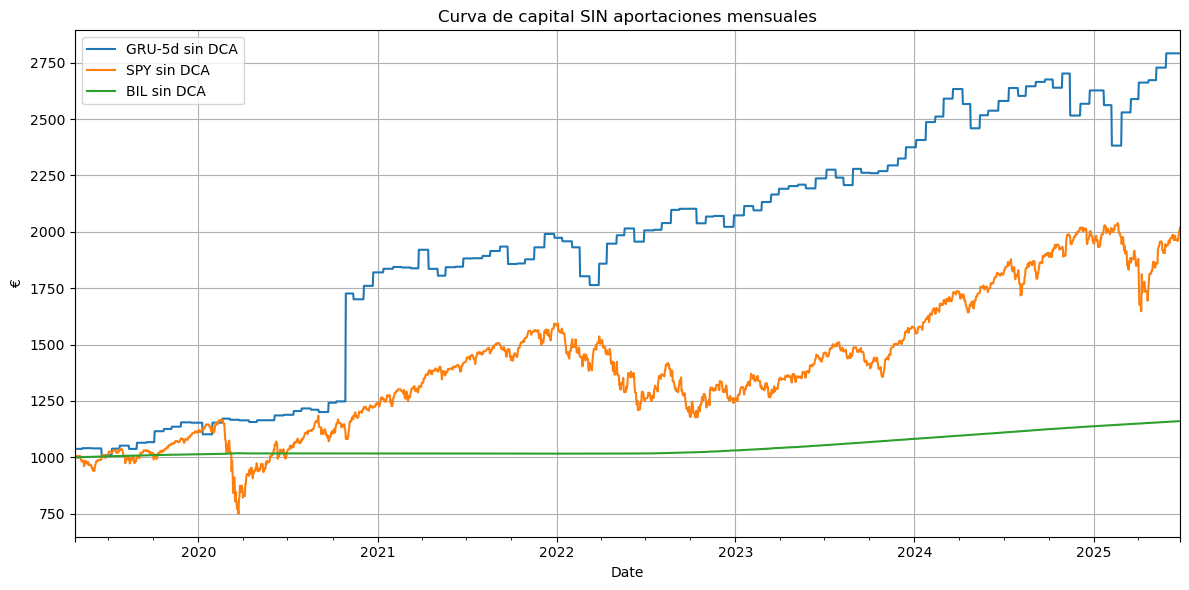

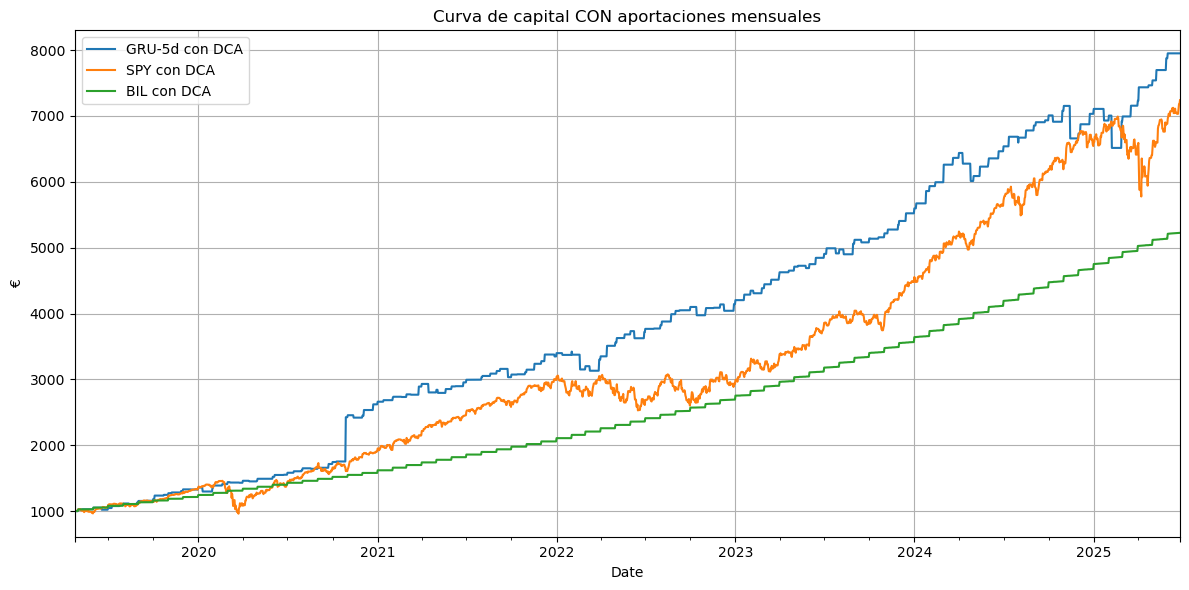


=== Métricas principales ===


,Rentabilidad acumulada (%),Volatilidad (%),Sharpe Ratio,Max Drawdown (%),Asimetría,Curtosis
GRU-5d,179.129575,15.543688,0.805098,0.0,26.471907,1040.791025
SPY,101.385732,17.162578,0.541989,0.0,-0.633243,20.612587
BIL,16.068645,0.223861,7.436752,0.0,1.429384,3.012206


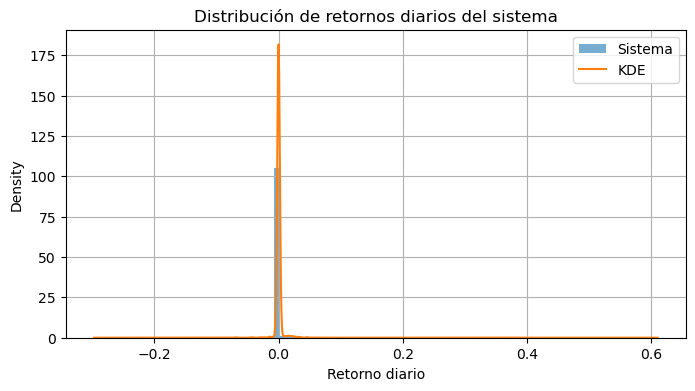

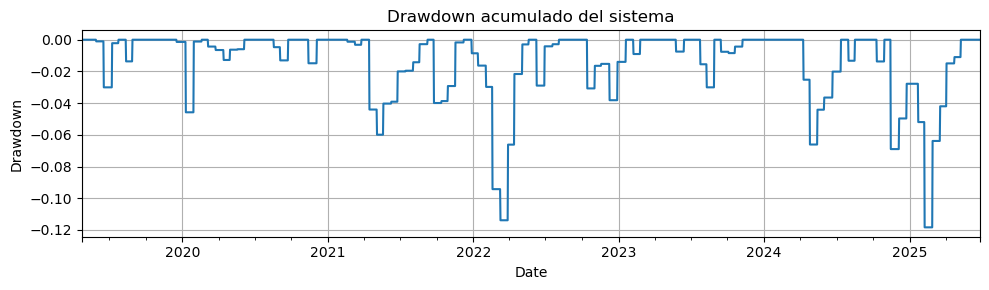

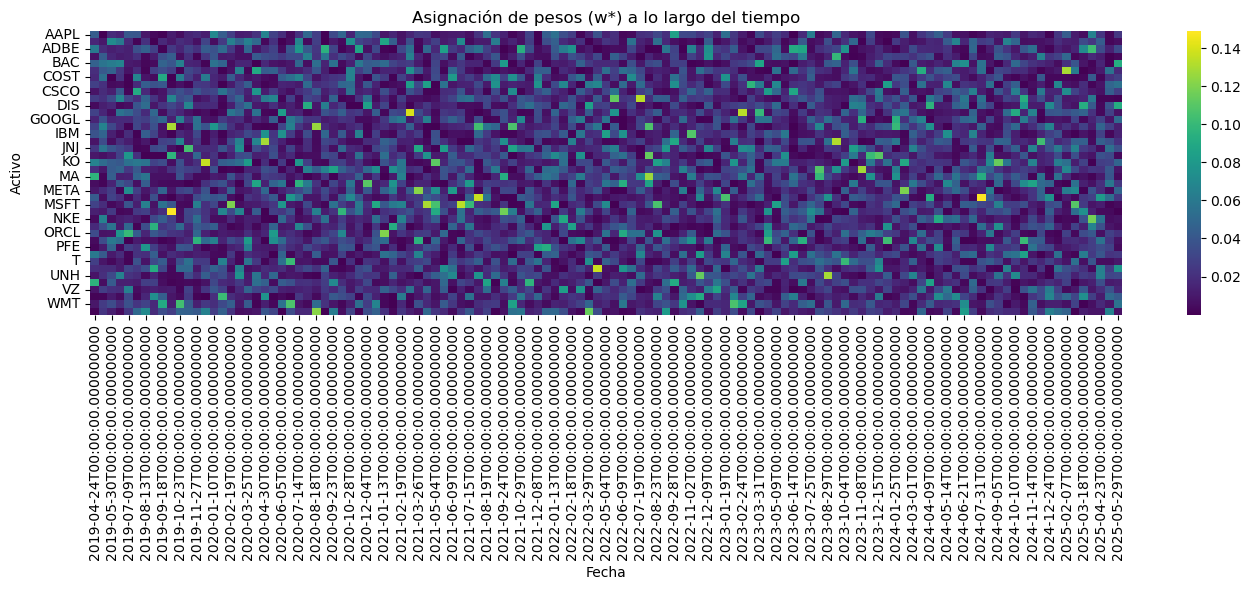

In [61]:
# 07_visualizaciones_gru5d.py  ───────────────────────────────────────────────
"""
Curvas de capital, métricas y heat-map de pesos para el modelo GRU-5d
(compatible con la estructura de proyecto TFM).
"""

# ╭─ 1. IMPORTS BÁSICOS ──────────────────────────────────────────────────────╮
import sys, pathlib, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import joblib
from scipy.stats import kurtosis, skew

warnings.filterwarnings("ignore", category=FutureWarning)

# Ruta al proyecto
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config as cfg

MODEL_NAME      = "gru5d"                 # <- nombre «corto» de tu nuevo modelo
RESULTS_PICKLE  = cfg.RESULT / f"backtest_{MODEL_NAME}.pkl"
PRICES_PARQUET  = cfg.DATA   / "raw" / "prices.parquet"

assert RESULTS_PICKLE.exists(), f"No existe {RESULTS_PICKLE}"
assert PRICES_PARQUET.exists(), f"No existe {PRICES_PARQUET}"

# ╭─ 3. CARGA DE RESULTADOS Y PRECIOS ────────────────────────────────────────╮
res_df      = joblib.load(RESULTS_PICKLE)            # índice = fecha
df_prices   = pd.read_parquet(PRICES_PARQUET).sort_index()

# Los pesos w_star tienen la misma longitud que los tickers originales
tickers = df_prices.columns[: res_df["w_star"].iloc[0].shape[0]]

ret_sys = res_df["retorno"].reindex(df_prices.index).fillna(0)  # Serie 1-D

# ╭─ 4. DESCARGA DE BENCHMARKS (SPY y BIL) ───────────────────────────────────╮
def get_prices_bench(tickers: list[str], start_date: pd.Timestamp) -> pd.DataFrame:
    """Descarga precios ajustados y devuelve DataFrame (index-fecha, cols-tickers)."""
    raw = yf.download(tickers, start=start_date, progress=False, auto_adjust=True)

    # Si viene con MultiIndex, nos quedamos con la columna de precios ajustados
    if isinstance(raw.columns, pd.MultiIndex):
        col0 = raw.columns.get_level_values(0)
        if "Adj Close" in col0:              # caso auto_adjust = False
            raw = raw["Adj Close"]
        elif "Close" in col0:                # caso auto_adjust = True
            raw = raw["Close"]
        else:                                # fallback
            raise KeyError("No encuentro Close/Adj Close tras la descarga")
    raw = raw.ffill()

    # yfinance con 1 solo ticker puede devolver Serie → forzamos DataFrame
    if isinstance(raw, pd.Series):
        raw = raw.to_frame()

    return raw


prices_bench = get_prices_bench(["SPY", "BIL"], ret_sys.index.min())
ret_bench    = np.log(prices_bench / prices_bench.shift(1)).dropna()
ret_bench    = ret_bench.reindex(ret_sys.index).fillna(0)

# ╭─ 5. APORTACIONES MENSUALES (DCA) ─────────────────────────────────────────╮
capital_ini = 1_000
aport_mes   = {2019: 25, 2020: 30, 2021: 40, 2022: 50, 2023: 60, 2024: 75, 2025: 75}

aport = pd.Series(0, index=ret_sys.index, dtype=float)
primer_dia_mes = aport.index.to_series().groupby(aport.index.to_period("M")).first()
for fecha in primer_dia_mes:
    if fecha.year in aport_mes:
        aport.at[fecha] = aport_mes[fecha.year]

# ╭─ 6. UTILIDADES ───────────────────────────────────────────────────────────╮
def curva_con_aportes(ret_series: pd.Series,
                      capital_ini: float,
                      aport_series: pd.Series) -> pd.Series:
    """Devuelve curva de capital aplicando aportes mensuales."""
    assert ret_series.ndim == 1, "ret_series debe ser Serie 1-D"
    wealth = pd.Series(index=ret_series.index, dtype=float)
    wealth.iloc[0] = capital_ini + aport_series.iloc[0]
    for t in range(1, len(ret_series)):
        wealth.iloc[t] = (wealth.iloc[t-1] + aport_series.iloc[t]) * (1 + ret_series.iloc[t])
    return wealth

def resumen_metricas(ret: pd.Series):
    """KPIs rápidos (acum., vol, Sharpe…) sobre una Serie de retornos diarios."""
    return {
        "Rentabilidad acumulada (%)": 100 * ((1 + ret).prod() - 1),
        "Volatilidad (%)"           : 100 * np.std(ret) * np.sqrt(252),
        "Sharpe Ratio"              : np.mean(ret) / np.std(ret) * np.sqrt(252)
                                       if np.std(ret) > 0 else np.nan,
        "Max Drawdown (%)"          : 100 * ((1 + ret).cumprod().cummax()
                                             - (1 + ret).cumprod()).min(),
        "Asimetría"                 : skew(ret),
        "Curtosis"                  : kurtosis(ret)
    }

# ╭─ 7. CURVAS DE CAPITAL ────────────────────────────────────────────────────╮
start_date   = ret_sys[ret_sys != 0].index[0]
ret_sys      = ret_sys.loc[start_date:]
ret_bench    = ret_bench.loc[start_date:]
aport        = aport.loc[start_date:]

# — SIN aportes
wealth_sys_ini  = (1 + ret_sys).cumprod() * capital_ini
wealth_spy_ini  = (1 + ret_bench["SPY"]).cumprod()
wealth_spy_ini  = wealth_spy_ini / wealth_spy_ini.iloc[0] * capital_ini
wealth_cash_ini = (1 + ret_bench["BIL"]).cumprod()
wealth_cash_ini = wealth_cash_ini / wealth_cash_ini.iloc[0] * capital_ini

# — CON aportes
wealth_sys_dca  = curva_con_aportes(ret_sys,        capital_ini, aport)
wealth_spy_dca  = curva_con_aportes(ret_bench["SPY"], capital_ini, aport)
wealth_cash_dca = curva_con_aportes(ret_bench["BIL"], capital_ini, aport)

# ╭─ 8. GRÁFICOS ─────────────────────────────────────────────────────────────╮
plt.figure(figsize=(12, 6))
wealth_sys_ini.plot(label="GRU-5d sin DCA")
wealth_spy_ini.plot(label="SPY sin DCA")
wealth_cash_ini.plot(label="BIL sin DCA")
plt.title("Curva de capital SIN aportaciones mensuales")
plt.ylabel("€")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 6))
wealth_sys_dca.plot(label="GRU-5d con DCA")
wealth_spy_dca.plot(label="SPY con DCA")
wealth_cash_dca.plot(label="BIL con DCA")
plt.title("Curva de capital CON aportaciones mensuales")
plt.ylabel("€")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ╭─ 9. MÉTRICAS ─────────────────────────────────────────────────────────────╮
metrics = pd.DataFrame({
    "GRU-5d": resumen_metricas(ret_sys),
    "SPY"   : resumen_metricas(ret_bench["SPY"]),
    "BIL"   : resumen_metricas(ret_bench["BIL"])
}).T
print("\n=== Métricas principales ===")
display(metrics)

# ╭─ 10. HISTOGRAMA DE RETORNOS ──────────────────────────────────────────────╮
plt.figure(figsize=(8, 4))
ret_sys.hist(bins=50, density=True, alpha=0.6, label="Sistema")
ret_sys.plot(kind="kde", label="KDE")
plt.title("Distribución de retornos diarios del sistema")
plt.xlabel("Retorno diario"); plt.grid(True); plt.legend(); plt.show()

# ╭─ 11. DRAWDOWN ────────────────────────────────────────────────────────────╮
cum_returns = (1 + ret_sys).cumprod()
drawdown    = cum_returns / cum_returns.cummax() - 1
plt.figure(figsize=(10, 3))
drawdown.plot()
plt.title("Drawdown acumulado del sistema")
plt.ylabel("Drawdown"); plt.grid(True); plt.tight_layout(); plt.show()

# ╭─ 12. HEATMAP DE PESOS ────────────────────────────────────────────────────╮
if "w_star" in res_df.columns and res_df["w_star"].notna().any():
    df_w = pd.DataFrame(
        [w for w in res_df["w_star"] if w is not None],
        index=res_df.dropna(subset=["w_star"]).index,
        columns=tickers
    )
    plt.figure(figsize=(14, 6))
    sns.heatmap(df_w.T, cmap="viridis", cbar=True)
    plt.title("Asignación de pesos (w*) a lo largo del tiempo")
    plt.xlabel("Fecha"); plt.ylabel("Activo"); plt.tight_layout(); plt.show()
else:
    print("⚠️  No hay columna 'w_star' en res_df → se omite heat-map.")
# ─────────────────────────────────────────────────────────────────────────────
